# Welcome!

Welcome to the first python notebook in the Autonomous materials discovery (47332) course. We will be using notebooks throughout the course. You might have to submit python scripts to the gbar high-performance computing system at DTU at some point if performing calculations in the notebook becomes too slow, but that is a bridge we will cross once we get there.

Since you are reading this, you have (probably) succesfully managed to log into the gbar, "source" the correct file, and open the python notebook.

You will get some basic information about course exercises in this notebook (consider it a teaser) with significantly more to follow on Monday. **The main purpose of this notebook is to verify that you can use the course software and that you can communicate with the robot.**

# Color mixing as a test system
In the course you will do recurrent exercises focused on mixing target colors. In practice we do this by mixing food colors diluted in water. Although we do perform significantly more complicated autonoums experiments in our daily research, mixing colored liquids is significantly closer to state-of-the-art for demonstration of autonomous orchestration than you might expect, as seen in [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0229862), which can also be found in the course group on DTU Inside. Sadly, we will not be doing the Tequilla Sunrise mixing also performed in that paper.

To give each group access to their very own robot, which can be operated without specialist knowledge and safety measures, we went with LEGO. Luckily, [someone](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2001413) already did most of the design for us, although we did have to modify and improve it in several ways. One major change we made to the robot is that we changed the operating system to a [Debian Linux-based system](https://www.ev3dev.org/). This allows us to use the programming language of our choice (Python, naturally) with all its flexibility and available modules. We thus have relatively easy access to state-of-the-art data science and machine learning software modules and could, in principle, run everyting directly on the LEGO EV3 brick computer. In practice the LEGO computer is rather slow once you begin doing semi-demanding operations such as training machine learning models, and we will thus run our main calculations on the gbar and send simple commands to the robot, which will execute them and pass back the result. More on that later in this notebook and later during the course.

We have also written an *in silico*, i.e. a purely software, surrogate model for the color mixing robot, SilicoColorMixer. It has the advantage that it requires less maintenance, is less prone to error and data noise (beyond the noise introduced into the model on purpose), and is significantly faster than the physical robot. The *in silico* model is not written in the most computationally efficient way but instead such that you can easily switch between the *in silico* color mixer and the robot color mixer software. We will be using the *in silico* color mixer in the course to test various algorithms etc. before applying the code to the physical robot.

## Exercise 0.1: Verify access to the SilicoColorMixer module

First, you should verify that you can import the SilicoColorMixer, begin and instance of it, and perform a simple color mixing calculation with it. Follow the cells below to try it out.

In [1]:
from silico_color_mixer import SilicoColorMixer

If this fails, chances are that you have not updated your .bashrc file with "source /zhome/0a/b/51514/47332_exercises/AMD2020.bashrc" such that Python knows where to find the module. This should have happened when you ran "source ~runch/47332_exercises/setup2020".

You will now initiate an instance of the SilicoColorMixer class. This is our model. In a later exercise we will go over it in detail. For now just execute:

In [2]:
mixer = SilicoColorMixer()

You can see the colors used in `mixer` and their rgb color codes. 

In [3]:
mixer.get_colors()

(['red_t', 'green_t', 'blue_t', 'yellow_t'],
 array([[220.,  35.,  40.],
        [ 73., 213.,   5.],
        [ 54.,  59., 212.],
        [249., 242.,  30.]]))

You will next try to mix a new color from these base colors, that the mixer has access to. You do this by providing a list of pseudo volumes of each base color. Note that the mixer does normalization for you, so the sum of the pseudo volumes is irrelevant. The `run_cuvette` method is called such to agree with the name in the LEGO robot software. A cuvette is a small container (here 4.5 ml) that we will mix the liquids in and can shine light into to obtain the color code of the result. 

In [4]:
output_color = mixer.run_cuvette([1.0, 0.0, 0.0, 2.0])

Visualize the output color.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

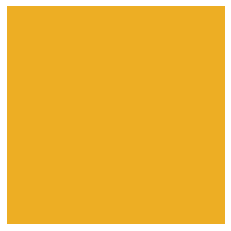

In [6]:
plt.axis('off')
plt.imshow(np.array([[output_color]], dtype=np.uint8))

Try it out for a bit by changing the input volumes list. You can rerun the cell multiple times with changed values in input_volumes.

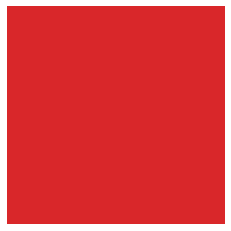

In [7]:
input_volumes=[1.0, 0.0, 0.0, 0.0]
output_color = mixer.run_cuvette(input_volumes)
plt.axis('off')
plt.imshow(np.array([[output_color]], dtype=np.uint8))

## Exercise 0.2: Verify access to the LEGO robot

You will now verify that you can communicate with the robot by making it speak to you! But first we need to get a few things out of the way.

You should have formed groups by now. Each group will have access to one shared robot and their own group space on the discord server. Ask me to post the name and password for your robot in there if I haven't already done so.

The robot control software is split into two parts: one running on the gbar and one running on the robot. SSH is used to connect from gbar to the robot. Once you have given the name and password as inputs during initialization of the gbar part of the control software, the connection should be handled for you. 

There is one small catch though. Image what an awful mess it could cause if two programs were simultaniously controlling the robot. To prevent this, only one python process is allowed on the robot at a time. It means you have to take turns executing your code on it. If you try to run while the robot is already busy you will see a so-called Traceback ending with this line.

Even though this helps, you can still mess up optimization runs badly by running more than program on the robot at a time if you are unlucky with timings such that the "only one python process" restriction is not triggered. You should thus be mindful of each other while running the robot.

Now, let's get ready to rumble! We will use **many** different packages and modules in this course. To help you keep track of what is being used and is required, you will install these packages on your own user as you go slowly bulding your environment. By typing ! in front of a line of code in the notebook, it will be executed as if you had put the line into the gbar command prompt. Try it out by running `!ls` to see the content of your current directory. Note that it might require a bit of patience before you see an output from `!` commands

In [8]:
!ls

Test_Connections.ipynb	Test_Positions.ipynb


We will use the `paramiko` package for ssh connections to the robot from within the local part of the control software - `AiLEGO_master`. Go ahead and install it now by running the cell below. 

In [9]:
!pip3 install --upgrade pip --user

In [10]:
!pip3 install --user --upgrade paramiko

Now go ahead and import the `AiLEGO_master` module.

In [11]:
from ailego_master import AiLEGO_master

Initiate an instance of the control software. It will prompt you for the name and password of your robot. Since the DNS server might not have assigned the robots probably, such that they are callable by their name, you might want to change to `local_ssh=True` and give the IP address instead of the name. The IP can be read on the robot display. We will load an instance that will not be able to run experiments but only make the robot speak.

In [22]:
speaking_robot = AiLEGO_master(speak_only=True, local_ssh=True)

Input robot name10.16.163.139
Robot password:········


Now make the robot say something. Be creative if you like. Note that the input has to be a string, i.e. surrounded by single or double quatation marks. Watch the camera to confirm the robot says what you want it to. Make sure to turn on the sound of the phone, tablet, device and the camera sound in the app. Note that it will take some time for the robot to execute your command as it needs to load drivers. 

In [23]:
say = 'rock! robot rock!'  # replace with your awesome catchphrase.

speaking_robot.make_robot_talk(say)

If the robot said something the sounds remotely like what you asked it to say, congratulations, you have succesfully confirmed that you can control it remotely.

This concludes this exercise. Well done!

In [ ]:
!ssh 10.16.163.139

In [ ]:
!yes